In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [172]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [173]:
cfg.run_name ='N2_352_3'
cfg.data_path.image_path = base_path + '/datasets/CodFish/N2_352-1.tif'
cfg.data_path.psf_path = base_path + '/decode_fish/data/N2_352_psf.pkl'
cfg.ground_truth = None
cfg.microscope.multipl = 200
cfg.pointprocess.min_int = 0.3
cfg.microscope.psf_extent_zyx = [21,21,21]
cfg.autoencoder.lr = 5e-5

cfg.supervised.num_iter = 10000
cfg.autoencoder.num_iter = 10000

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

Store the config as an experiment

In [174]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [23]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

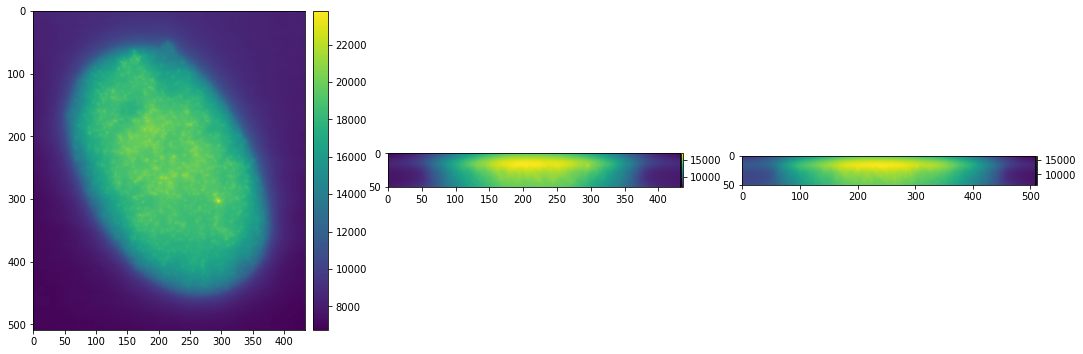

In [24]:
_ = plot_3d_projections(img_3d)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

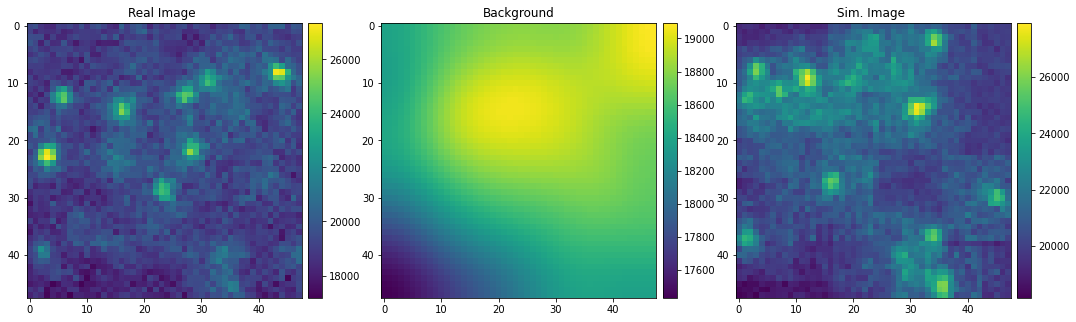

In [26]:
get_simulation_statistics(decode_dl, micro, int_threshold=10000)

Command to train a model on the gpu cluster

In [26]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ocodsub.log -e {home_dir}/logs/ecodesub.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ocodsub.log -e /groups/turaga/home/speisera/logs/ecodesub.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=N2_352_3'

# Evaluation

In [27]:
cfg = OmegaConf.load(f'config/experiment/N2_352_3.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_3/autoencoder.lr:5e-05/train.yaml')

In [28]:
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
psf_init, noise, micro = load_psf_noise_micro(cfg)
psf_init.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_init.pkl'))

psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

<All keys matched successfully>

In [30]:
img_3d, decode_dl = get_dataloader(cfg)

Plot projections of the PSF before and after optimizing it during training

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

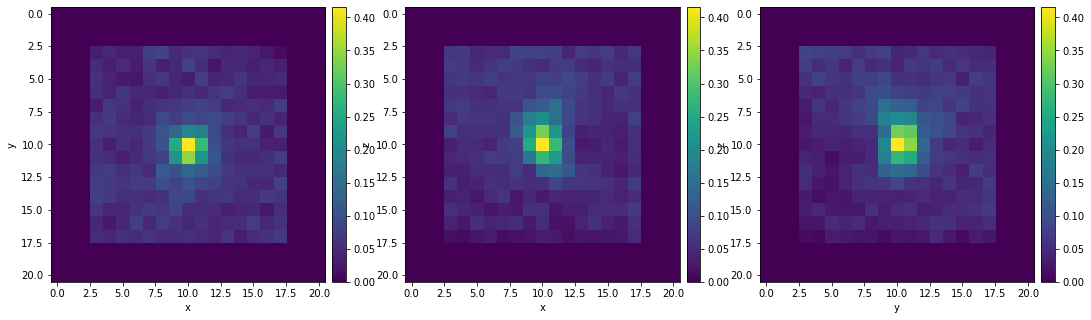

In [35]:
plot_3d_projections(psf_init.psf_volume[0],'max')

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

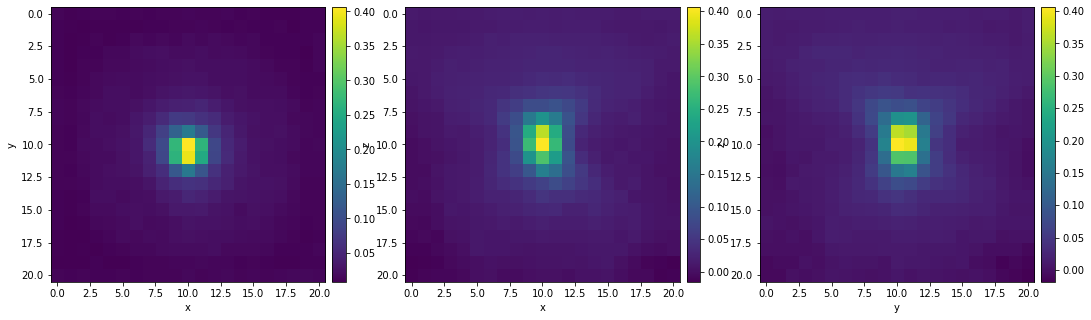

In [36]:
plot_3d_projections(psf.psf_volume[0],'max')

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

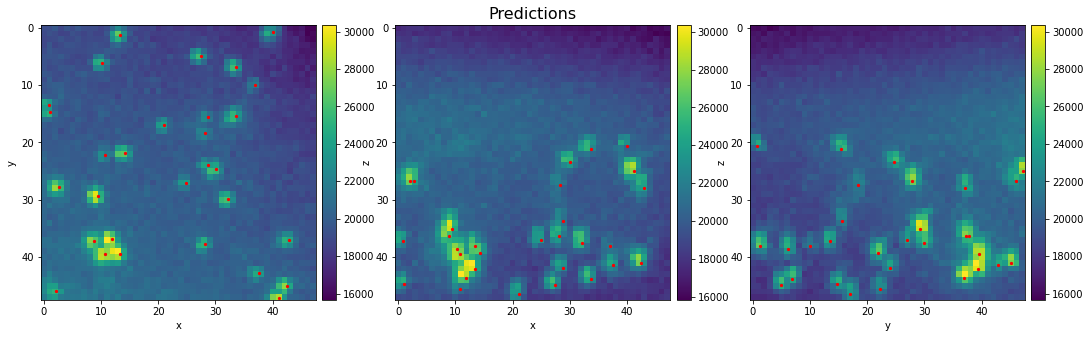

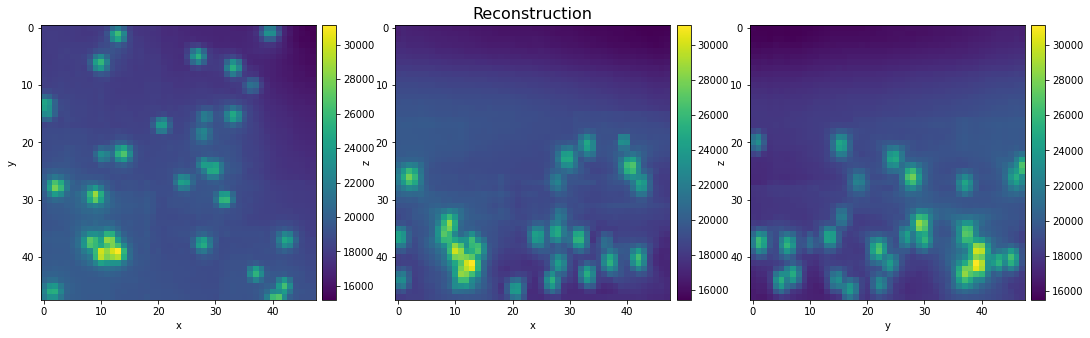

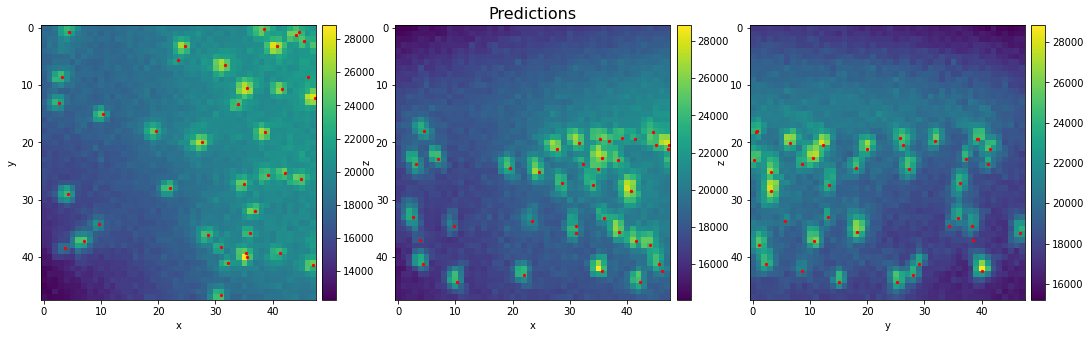

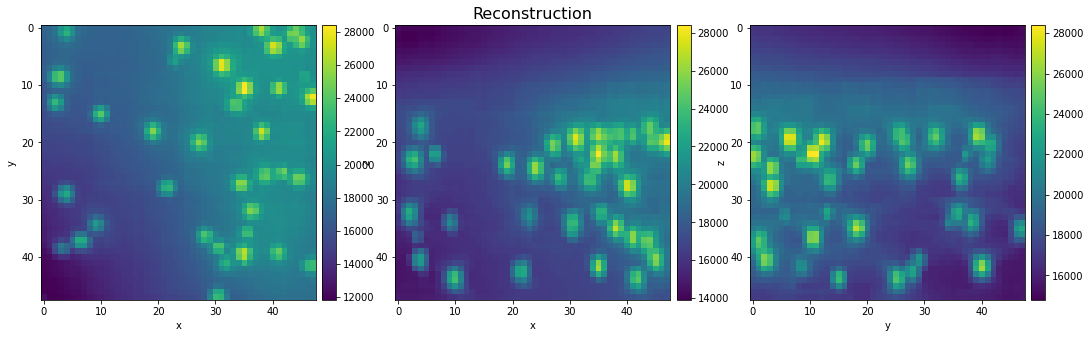

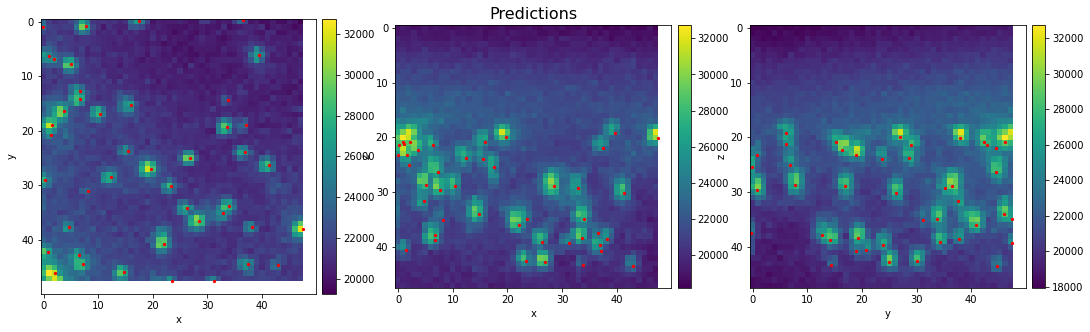

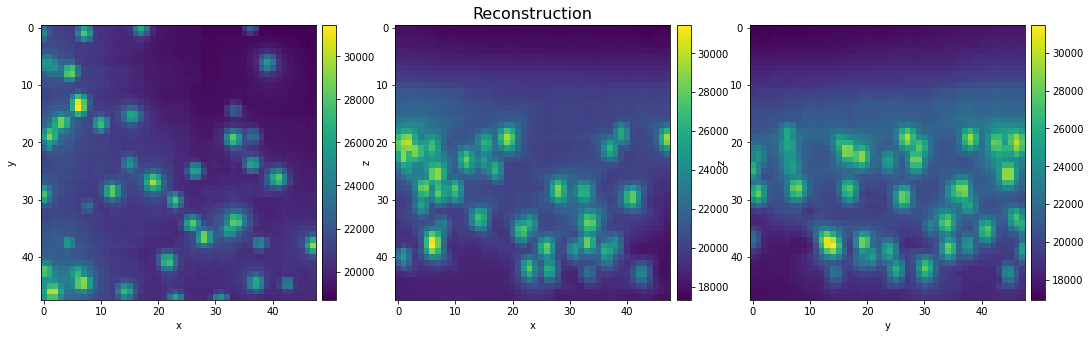

In [37]:
eval_random_crop(decode_dl, model, micro, projection='max', threshold=0.1, samples=3)

In [15]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])
    pred_df = model_output_to_df(res, 0.1, px_size=[100,100,100])
    free_mem()

Inferred intensities

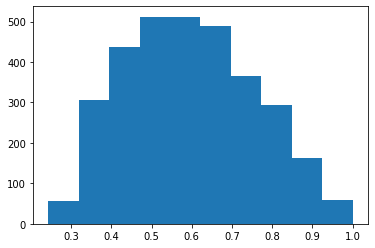

In [16]:
_ = plt.hist(pred_df['int'])

In [17]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [18]:
vol = img_3d.numpy()

extent = [[-s/2,s/2] for s in vol.shape]
extent = [extent[i] for i in [2,1,0]]

ipv.figure()
ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
ipv.xyzlim(max(vol.shape)/2)
ipv.view(90, 40)
ipv.show()

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/ipyvolume/widgets.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/ipyvolume/utils.py:204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2])/2
